In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_excel('../data/sales_2014-2016.xlsx', sheet_name='TDSheet', skiprows=7, index_col=0)
df_2 = pd.read_excel('../data/sales_2017-2018.xlsx', sheet_name='TDSheet', skiprows=7, index_col=0)
df_3 = pd.read_excel('../data/sales_2019-2020.xlsx', sheet_name='TDSheet', skiprows=7, index_col=0)
df_4 = pd.read_excel('../data/sales_2021-2022.xlsx', sheet_name='TDSheet', skiprows=7, index_col=0)
data = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [50]:
df = data.copy()

In [51]:
df.columns

Index(['По годам', 'По месяцам', 'По неделям', '.Юнит (св-во Грузополучатель)',
       '.Канал дистрибуции КН (св-во Грузополучатель)',
       '.РМ КН (св-во Грузополучатель)', 'Ключевой контрагент', 'Контрагент',
       '.Товарная группа (св-во Номенклатура)',
       '.Линия пр-ва (св-во Номенклатура)', 'Вид (св-во Номенклатура)',
       '.Бренд КН (св-во Номенклатура)', '.Тип Фасовки (св-во Номенклатура)',
       'Фасовка (св-во Номенклатура)',
       'Вид упаковки нов. (св-во Номенклатура)', 'Артикул', 'Штрихкод (шт)',
       'Ключевая номенклатура', 'Номенклатура', 'Количество',
       'Количество (в ед. отчетов)', 'Количество (в базовых единицах)',
       'Сумма продажи в руб.'],
      dtype='object')

In [52]:
df = df.loc[data['Штрихкод (шт)'] == 4604248009649]
df = df.groupby('По неделям', as_index=False)['Сумма продажи в руб.'].sum()
df.columns

Index(['По неделям', 'Сумма продажи в руб.'], dtype='object')

In [53]:
df['date'] = pd.to_datetime(df['По неделям'].str.extract(r'(\d{2}\.\d{2}\.\d{4})')[0], format='%d.%m.%Y')

# Стартовая дата
start_date = pd.to_datetime('13.01.2014', format='%d.%m.%Y')

# Сквозная нумерация недель
df['week_index'] = ((df['date'] - start_date).dt.days // 7) + 1

In [54]:
df = df.sort_values(by=['week_index'])

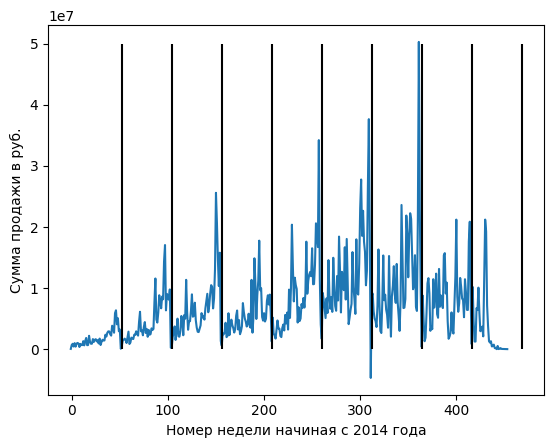

In [55]:
plt.plot(df['week_index'], df['Сумма продажи в руб.'])
plt.xlabel('Номер недели начиная с 2014 года')
plt.ylabel('Сумма продажи в руб.')
for k in range(1, 10):
    plt.vlines(52*k, 0, 5e7, color='k')

In [56]:
# df — ваш датафрейм, 'date' — начало недели, 'sales' — продажи
df['date'] = pd.to_datetime(df['date'])

# Признак: недели до/после Нового года
df['weeks_to_newyear'] = df['date'].apply(lambda d: (pd.Timestamp(year=d.year, month=1, day=1) - d).days // 7)

# Признак: сезон
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'
df['season'] = df['date'].apply(get_season)

In [57]:
from prophet import Prophet

# Переименуем столбцы
df = df.rename(columns={'date': 'ds', 'Сумма продажи в руб.': 'y'})

# Кодируем сезон (one-hot)
df = pd.concat([df, pd.get_dummies(df['season'])], axis=1)

In [108]:
years = range(df['ds'].dt.year.min(), df['ds'].dt.year.max() + 1)
holidays = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime([f'{y}-01-01' for y in years]),
    'lower_window': -28,  # за 2 недели до праздника
    'upper_window': 1     # и 1 день после
})

In [110]:
df

,По неделям,y,ds,week_index,weeks_to_newyear,season,autumn,spring,summer,winter
441,Неделя с 30.12.2013,52069.20,2013-12-30,-1,-52,winter,False,False,False,True
73,Неделя с 06.01.2014,700991.41,2014-01-06,0,-1,winter,False,False,False,True
178,Неделя с 13.01.2014,888135.70,2014-01-13,1,-2,winter,False,False,False,True
281,Неделя с 20.01.2014,436139.09,2014-01-20,2,-3,winter,False,False,False,True
384,Неделя с 27.01.2014,994776.90,2014-01-27,3,-4,winter,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
262,Неделя с 18.07.2022,84175.86,2022-07-18,445,-29,summer,False,False,True,False
365,Неделя с 25.07.2022,178581.06,2022-07-25,446,-30,summer,False,False,True,False
10,Неделя с 01.08.2022,47399.95,2022-08-01,447,-31,summer,False,False,True,False
114,Неделя с 08.08.2022,42638.76,2022-08-08,448,-32,summer,False,False,True,False


In [111]:
m = Prophet(holidays=holidays, 
            yearly_seasonality=True, 
            weekly_seasonality=False,
            n_changepoints=50,
            changepoint_range=0.95,
            changepoint_prior_scale=0.5,
            )
m.add_regressor('weeks_to_newyear')
for season in ['winter', 'spring', 'summer', 'autumn']:
    m.add_regressor(season)

m.fit(df)

16:39:34 - cmdstanpy - INFO - Chain [1] start processing
16:39:34 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
future = m.make_future_dataframe(periods=1, freq='W')
future['weeks_to_newyear'] = future['ds'].apply(lambda d: (pd.Timestamp(year=d.year, month=1, day=1) - d).days // 7)
future['season'] = future['ds'].apply(get_season)
future = pd.concat([future, pd.get_dummies(future['season'])], axis=1)

forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))


            ds          yhat    yhat_lower    yhat_upper
451 2022-09-18  2.632090e+06 -1.634289e+06  7.068818e+06


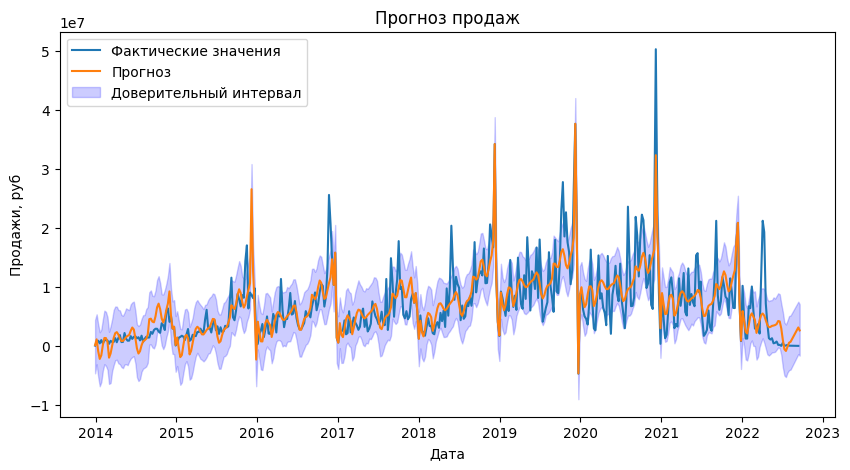

In [114]:
cut = 1000000
plt.figure(figsize=(10, 5))
plt.plot(df['ds'][:cut], df['y'][:cut], label='Фактические значения')
plt.plot(forecast['ds'][:cut], forecast['yhat'][:cut], label='Прогноз')
plt.fill_between(forecast['ds'][:cut], forecast['yhat_lower'][:cut], forecast['yhat_upper'][:cut], color='blue', alpha=0.2, label='Доверительный интервал')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Продажи, руб')
plt.title('Прогноз продаж')
plt.show()

In [115]:
len(forecast['yhat'])


452

In [104]:
len(df['y'])

451

In [116]:
merged = pd.merge(df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Теперь длины совпадают, можно сравнивать
y_true = merged['y'][1:]
y_pred = merged['yhat'][1:]

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# y_true — реальные значения, y_pred_prophet — прогноз Prophet, y_pred_naive — прогноз наивной модели

# Наивный прогноз (shift на одну неделю назад)
y_pred_naive = df['y'].shift(1)[1:]

# Prophet прогноз (должен быть синхронизирован по датам с y_true)
# y_pred_prophet = forecast['yhat'][1:]  # если forecast совпадает по индексам

# Метрики для Prophet
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred)

# Метрики для наивной модели
mae_naive = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))
mape_naive = mean_absolute_percentage_error(y_true, y_pred_naive)

print(f"Prophet MAE: {mae_prophet:.2f}, Naive MAE: {mae_naive:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}, Naive RMSE: {rmse_naive:.2f}")
print(f"Prophet MAPE: {mape_prophet*100:.2f}%, Naive MAPE: {mape_naive*100:.2f}%")


Prophet MAE: 2431988.02, Naive MAE: 3253212.44
Prophet RMSE: 3558800.60, Naive RMSE: 5133519.70
Prophet MAPE: 185.73%, Naive MAPE: 88.23%


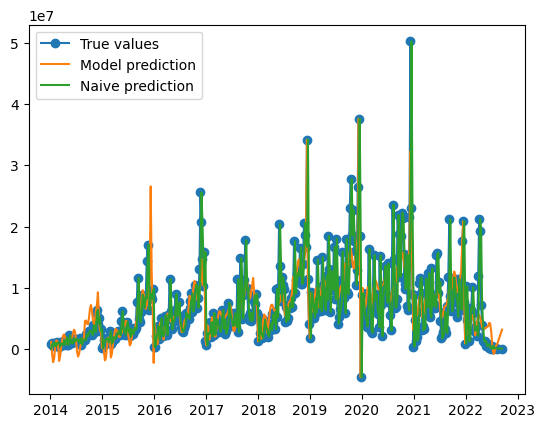

In [118]:
plt.plot(df['ds'][1:], y_true, '-o', label='True values')
plt.plot(df['ds'][1:], y_pred, label='Model prediction')
plt.plot(df['ds'][1:], y_pred_naive, label='Naive prediction')
plt.legend()